The proposed intrusion detection system in [1] detects whether a packet contains a potential attack. We have created a response that can be implemented to such systems.. If a packet is deemed safe, it will go through a hash-based message authentication code process where it will receive a key for further processing.

In [1]:
import pandas as pd  # type: ignore
import hmac
import hashlib

# Path to the CSV file
file_path = 'CICIDS2017_sample.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)


In [2]:
benign_count = 0
attack_count = 0

for status in df['Label']:
    if status == 'BENIGN':
        benign_count += 1
    else:  
        attack_count += 1

Safe: 22731 
Attack detected: 33930


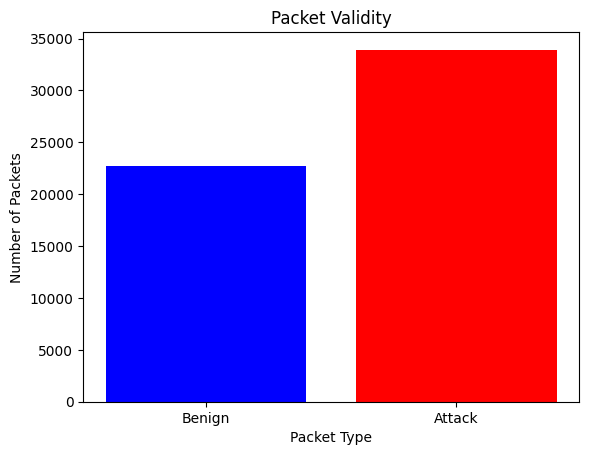

In [3]:
import matplotlib.pyplot as plt  # type: ignore

print(f'Safe: {benign_count} ')
print(f'Attack detected: {attack_count}')

packet_counts = {'Benign': benign_count, 'Attack': attack_count}

plt.bar(packet_counts.keys(), packet_counts.values(), color=['blue', 'red'])
plt.title("Packet Validity")
plt.xlabel("Packet Type")
plt.ylabel("Number of Packets")
plt.show()

The following columns in each row are encrypted into a key: Active Min, Idle Mean, Idle Std, Idle Max, Idle Min, and Label. This results in a secure hash-based message authentication code for every valid packet.

In [4]:
def applyhmac(row):
    #Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
    # data = f"{row['Active Min']}, {row['Idle Mean']}, {row['Idle Std']}, {row['Idle Max']}, {row['Idle Min']}, {row['Label']}".encode()
    data = ', '.join(map(str, row.values)).encode()
    secret_key= b'thisisthekey'
    hmac_result = hmac.new(secret_key, data, hashlib.sha256)

    return hmac_result.hexdigest()

If a packet is benign, the HMAC function will be applied.

In [5]:
df['HMAC'] = df.apply(lambda row: applyhmac(row) if row['Label'] == 'BENIGN' else "notvalid", axis=1)

In [6]:
df.to_csv('benign_with_hmac.csv', index=False)

In [7]:
df = pd.read_csv('benign_with_hmac.csv')
(df['HMAC'])

0        9bb18b548b6971c329a013ad8d2c9c76769e126c7e3b8c...
1        0b0c4a42e5f4a0f56b58b48ff796e05c377d697ccdddf6...
2        4954bbe87c8c7dfab285cb9b5f0cd18ed79eb4cc1c27b6...
3        b98cd48fbeb6f8cd734d425eba9dc848c884b17d7e9a47...
4        5c7b2d34fe1f12eb4818e35413c6b73e0b23898d96f41e...
                               ...                        
56656    ed85044a6ee7e9db52903373f9c7d8075f7a6f2844ba43...
56657    945dd7a3ab757d494d3c7edbbddfddc7b321e95648fe3e...
56658                                             notvalid
56659                                             notvalid
56660                                             notvalid
Name: HMAC, Length: 56661, dtype: object

In [8]:
hashed_count = 0
blocked = 0

for status in df['Label']:
    if status == 'BENIGN':
        hashed_count += 1
    else:  
        blocked += 1

Accepted Packets: 22731 
Blocked Packets: 33930


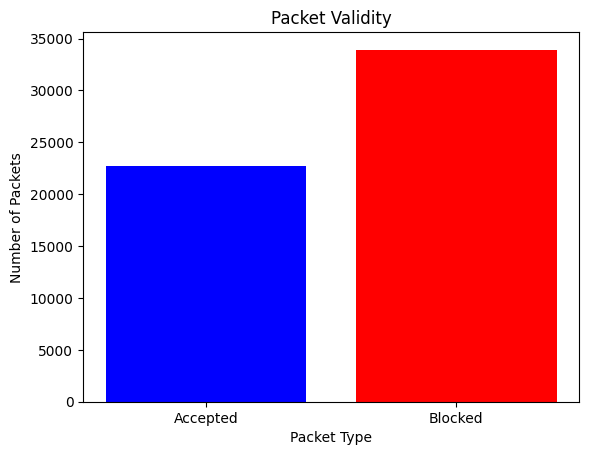

In [ ]:
import matplotlib.pyplot as plt  # type: ignore

print(f'Accepted Packets: {hashed_count} ')
print(f'Blocked Packets: {blocked}')

packet_counts = {'Accepted': hashed_count, 'Blocked': blocked}

plt.bar(packet_counts.keys(), packet_counts.values(), color=['blue', 'red'])
plt.title("Packet Validity")
plt.xlabel("Packet Type")
plt.ylabel("Number of Packets")
plt.show()

In [ ]:
# HMAC verification function
def verify_hmac(row, secret_key):
    
    data = ', '.join(map(str, row.drop(labels=['HMAC']).values)).encode()  
    # use the shared secret key
    computed_hmac = hmac.new(secret_key, data, hashlib.sha256).hexdigest()
    
    return computed_hmac == row['HMAC']

file_path = 'benign_with_hmac.csv'


In [ ]:

# Read the file into a DataFrame
df = pd.read_csv(file_path)

# shared secret key
shared_key = b'thisisthekey'

# Apply the verification function 
df['Valid'] = df.apply(lambda row: verify_hmac(row, shared_key), axis=1)

# Save the verification results
output_file = 'verified_packets.csv'
df.to_csv(output_file, index=False)

# RESULTS 
valid_count = df['Valid'].sum()
invalid_count = len(df) - valid_count


In [ ]:

print(f"Valid Packets: {valid_count}")
print(f"Invalid Packets: {invalid_count}")
print(f"Verification results saved to: {output_file}")


Valid Packets: 22731
Invalid Packets: 33930
Verification results saved to: verified_packets.csv


Simulation of packet processing without HMAC

In [ ]:
import socket

def send_packet_to_vehicle(packet_data):
    vehicle_ip = "127.0.0.1"  # Localhost for testing
    vehicle_port = 8080  # Port to send the packet to

    # Create a UDP socket to send the packet
    client_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    client_socket.sendto(packet_data.encode(), (vehicle_ip, vehicle_port))
    client_socket.close()
    print(f"Sent packet: {packet_data}")

# Example: Sending the "Label" column data over UDP
file_path = 'CICIDS2017_sample.csv'
df = pd.read_csv(file_path)

# Send packets only for Benign and Attack labels
for index, row in df.iterrows():
    packet_data = row['Label']  # Only send the "Label" (Benign/Attack)
    send_packet_to_vehicle(packet_data)

Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN
Sent packet: BENIGN


In [14]:
def simulate_vehicle_server():
    print("Vehicle listening for packets ...")
    vehicle_ip = "127.0.0.1"  # Can be modified to actual vehicle IP)
    vehicle_port = 8080  # Port for listening to packets

    # Create a UDP socket for the vehicle to receive packets
    vehicle_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    vehicle_socket.bind((vehicle_ip, vehicle_port))

    send_packet_to_vehicle(packet_data)

    flag = True

    while flag:
            packet, addr = vehicle_socket.recvfrom(1024)  # Max packet size 1024 bytes
            print(f"Received packet from {addr}: {packet.decode()}")

    vehicle_socket.close()

simulate_vehicle_server()


Vehicle listening for packets ...
Sent packet: DoS
Received packet from ('127.0.0.1', 55096): DoS


KeyboardInterrupt: 